# 1. Importando as bibliotecas que serão utilizadas:

In [167]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yahoofinancials as yf
import yfinance as yfin
yfin.pdr_override()
from scipy import optimize as op
import scipy.optimize as sco

# 2. Escolher as ações que vão compor a carteira e datas que serão utilizadas:


In [168]:
print('////////////////////////////////////////////////////////////////////////////')
print('Primeiramente, quantas ações compõem a carteira? ')
num_acoes = int(input('número de ações -->'))
print('Agora, indique quais as ações que compõem a carteira:')
print('OBS: para ações brasileiras - "ticker.SA" e para americanas apenas seu ticker. ')
t = []
for i in range(num_acoes):
    acao = input('ação --> ')
    t.append(acao)
print('Sua carteira é formada por:',t)
print('////////////////////////////////////////////////////////////////////////////')
print('Qual período quer analisar?')
print('OBS: colocar as datas no seguinte formato: aaaa-mm-dd')
inicio = input('data de início --> ')
fim = input('data final --> ')
print('////////////////////////////////////////////////////////////////////////////')
print('Por fim, qual a frequência na qual os dados devem ser coletados?')
print('OBS: diário = "daily", semanal = "weekly", mensal = "monthly"')
freq = input('frequência -->')
print('////////////////////////////////////////////////////////////////////////////')

////////////////////////////////////////////////////////////////////////////
Primeiramente, quantas ações compõem a carteira? 


número de ações --> 4


Agora, indique quais as ações que compõem a carteira:
OBS: para ações brasileiras - "ticker.SA" e para americanas apenas seu ticker. 


ação -->  ITUB3.SA
ação -->  ABEV3.SA
ação -->  VALE3.SA
ação -->  ENBR3.SA


Sua carteira é formada por: ['ITUB3.SA', 'ABEV3.SA', 'VALE3.SA', 'ENBR3.SA']
////////////////////////////////////////////////////////////////////////////
Qual período quer analisar?
OBS: colocar as datas no seguinte formato: aaaa-mm-dd


data de início -->  2019-01-01
data final -->  2022-01-01


////////////////////////////////////////////////////////////////////////////
Por fim, qual a frequência na qual os dados devem ser coletados?
OBS: diário = "daily", semanal = "weekly", mensal = "monthly"


frequência --> weekly


////////////////////////////////////////////////////////////////////////////


# 3. Transformando os dados requeridos em um data Frame contendo as datas e os preços de fechamento ajustado:

In [169]:
ticker = yf.YahooFinancials(t).get_historical_price_data(inicio, fim, freq) #busca os dados para a ação escolhida

colunas = []
carteira = pd.DataFrame()
for j in range(len(t)):
    dados = pd.DataFrame(ticker[t[j]]['prices']) #cria o DataFrame com os dados obtidos
    dados = dados.drop(['high','low','open','volume','close','date'],axis=1) #deleta essas colunas
    dados.rename(columns={'formatted_date' : 'Data', 'adjclose' : 'Fechamento-'+ t[j]}, inplace=True) #renomeia essas colunas
    carteira[t[j]] = dados['Fechamento-'+ t[j]] #adiciona ao DataFrame final apenas os dados de fechamento ajustado de cada ação escolhida
    colunas.append(t[j])
carteira['Data'] = dados['Data']
carteira

,ITUB3.SA,ABEV3.SA,VALE3.SA,ENBR3.SA,Data
0,28.214632,14.985546,39.734982,11.430275,2019-01-01
1,28.562691,15.949422,40.263142,12.444646,2019-01-08
2,28.202364,16.367708,42.314571,12.977036,2019-01-15
3,28.483589,16.322243,32.424843,13.950315,2019-01-22
4,29.380024,16.776901,34.200710,14.374565,2019-01-29
...,...,...,...,...,...
152,20.745413,15.476024,72.964821,19.413448,2021-11-30
153,19.411222,15.408653,74.977448,19.322859,2021-12-07
154,18.973675,14.840814,75.381897,18.933321,2021-12-14
155,19.341614,15.530000,76.027092,18.924261,2021-12-21


# 4. Gráfico do preços dos ativos que compõe a carteira ao longo do período:

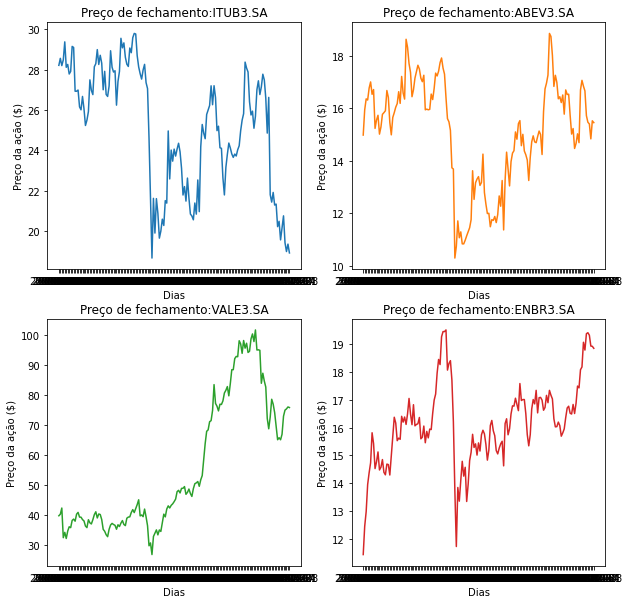

In [170]:
figura = plt.figure(figsize=(10,10))
colors = plt.rcParams["axes.prop_cycle"]()
for i in range(len(t)):
    c = next(colors)["color"]
    figura.add_subplot(2,2,i+1)
    plt.plot(carteira['Data'],carteira[colunas[i]],color=c) #
    plt.title('Preço de fechamento:'+colunas[i])
    plt.ylabel('Preço da ação ($)')
    plt.xlabel('Dias')
plt.show()

# 5. Cálculo dos retornos para os dados coletados:

In [171]:
#define uma função para os log-retornos diários
def retornos(fechamento):
    retornos=[0] #o primeiro dado será vazio pois não é possível o cálculo do retorno para ele
    for i in range(1,len(fechamento)): 
         retornos.append(np.log(fechamento[i]/fechamento[i-1])) #cálculo do log-retorno
    return np.array(retornos)

Retorno = pd.DataFrame()
for i in range(len(t)):
    Retorno['Retornos-'+t[i]] = retornos(carteira[t[i]]) #cálculo dos retornos passando por cada coluna do DataFrame, ou seja, por cada ação da carteira
Retorno.set_index(carteira['Data'])

,Retornos-ITUB3.SA,Retornos-ABEV3.SA,Retornos-VALE3.SA,Retornos-ENBR3.SA
Data,,,,
2019-01-01,0.000000,0.000000,0.000000,0.000000
2019-01-08,0.012261,0.062336,0.013205,0.085025
2019-01-15,-0.012696,0.025888,0.049695,0.041891
2019-01-22,0.009922,-0.002782,-0.266207,0.072321
2019-01-29,0.030987,0.027474,0.053322,0.029958
...,...,...,...,...
2021-11-30,0.029157,-0.016040,0.086376,0.001868
2021-12-07,-0.066474,-0.004363,0.027210,-0.004677
2021-12-14,-0.022799,-0.037548,0.005380,-0.020365


# 6. Cálculos:

In [236]:
print('-------------------------------------------------------------------------------------------------------')
print('Qual o número de simulações a serem feitas?')
n_simulacoes = int(input('n° de simulações -->'))
print('-------------------------------------------------------------------------------------------------------')

rf = 0.05 #taxa livre de risco

if freq == 'daily': #define um multiplicador, assim, buscando anualizar os dados calculados
    multiplicador = 252 
elif freq == 'weekly':
    multiplicador = 52
elif freq == 'monthly':
    multiplicador = 12

media = Retorno.mean() #média dos retornos das ações da carteira
cov = Retorno.cov() #covariância dos retornos
    
print('A média dos retornos de cada ativo foi:')
print(media*multiplicador)
print('-------------------------------------------------------------------------------------------------------')
print('Já a tabela de covariância é dada por:')
print(cov*multiplicador)
print('-------------------------------------------------------------------------------------------------------')

peso_acoes = []
retorno_simulacoes = []
desvio_simulacoes = []
sharpe_index = []
for i in range(n_simulacoes):

    peso = np.random.random(num_acoes) #calcula pesos aleatórios para as ações da carteira
    peso /= np.sum(peso) #e esses pesos devem somar 1
    
    retorno_simulacoes.append(np.sum(peso*media)*multiplicador) #calcula o retorno da carteira com base nos retornos de cada ação e seus pesos na carteira
    desvio_simulacoes.append(np.sqrt(np.dot(peso.T, np.dot(cov*multiplicador,peso)))) #calcula o desvio padrão da carteira
    peso_acoes.append(peso)
retorno_simulacoes = np.array(retorno_simulacoes)
desvio_simulacoes = np.array(desvio_simulacoes)

sharpe_index = []
for i in range(n_simulacoes):
    sharpe_index.append((retorno_simulacoes-rf)/desvio_simulacoes) #calcula o índice de sharpe da carteira
sharpe_index = np.array(sharpe_index[0])

dic = {'Retorno' : retorno_simulacoes,  #criado um dicionário para os valores criados acima
       'Desvio Padrão': desvio_simulacoes,
       'Sharpe': sharpe_index}
simulacoes_carteira = pd.DataFrame(dic)  #dicionário é transformado em um DataFrame

dic2 = {}
pesos_simulacoes = pd.DataFrame()
for j in range(0, n_simulacoes):
    for i in range(0,len(t)):
        peso = peso_acoes[j][i] #pega os pesos das ações um por um
        dic2["Peso " + t[i]] = [peso] #e armazena eles em um dicionário, assim, deixando cada peso simulado de cada ação na sua própria coluna
    df_dic2 = pd.DataFrame(dic2)
    
    pesos_simulacoes = pd.concat([pesos_simulacoes, df_dic2], axis = 0) 
    
simulacoes_carteira.reset_index(drop = True, inplace=True)
pesos_simulacoes.reset_index(drop = True, inplace=True)
resultados_simulacoes_carteira = pd.concat([simulacoes_carteira,pesos_simulacoes], axis = 1) #DataFrame que contém o resultados das simulações (retorno, desvio padrão e sharpe para cada combinação de pesos), além dos pesos de cada ativo em cada simulaçãpo
print('Tabela com os resultados das simulações:')
print(resultados_simulacoes_carteira)
print('-------------------------------------------------------------------------------------------------------')

-------------------------------------------------------------------------------------------------------
Qual o número de simulações a serem feitas?


n° de simulações --> 1000


-------------------------------------------------------------------------------------------------------
A média dos retornos de cada ativo foi:
Retornos-ITUB3.SA   -0.132638
Retornos-ABEV3.SA    0.010324
Retornos-VALE3.SA    0.214068
Retornos-ENBR3.SA    0.165718
dtype: float64
-------------------------------------------------------------------------------------------------------
Já a tabela de covariância é dada por:
                   Retornos-ITUB3.SA  Retornos-ABEV3.SA  Retornos-VALE3.SA  \
Retornos-ITUB3.SA           0.112917           0.069781           0.034831   
Retornos-ABEV3.SA           0.069781           0.135623           0.014888   
Retornos-VALE3.SA           0.034831           0.014888           0.153417   
Retornos-ENBR3.SA           0.054452           0.050255           0.017638   

                   Retornos-ENBR3.SA  
Retornos-ITUB3.SA           0.054452  
Retornos-ABEV3.SA           0.050255  
Retornos-VALE3.SA           0.017638  
Retornos-ENBR3.SA           0.0

# 7. Gráfico do conjunto de simulações:

<AxesSubplot:xlabel='Desvio Padrão', ylabel='Retorno'>

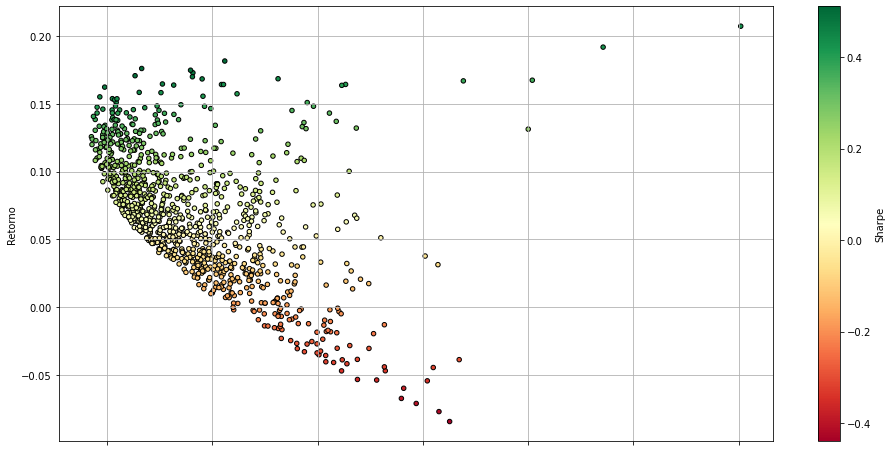

In [237]:
resultados_simulacoes_carteira.plot.scatter(x ='Desvio Padrão', y ='Retorno',c ='Sharpe',figsize=(16,8), grid = True, cmap='RdYlGn', edgecolors= 'black') #  

# 8. Identificando a carteira de maior Sharpe:

In [238]:
maior_sharpe = resultados_simulacoes_carteira['Sharpe'].max() #acha o maior Sharpe entre as simulações
carteira_maior_sharpe = resultados_simulacoes_carteira.loc[resultados_simulacoes_carteira['Sharpe'] == maior_sharpe] #acha os pesos dos ativos que geram a carteira com o maior Sharpe

print(f'O maior sharpe é {round(maior_sharpe,3)}, da carteira que apresentou os seguintes resultados:{carteira_maior_sharpe.T}')

O maior sharpe é 0.511, da carteira que apresentou os seguintes resultados:                     60
Retorno        0.175972
Desvio Padrão  0.246589
Sharpe         0.510860
Peso ITUB3.SA  0.015570
Peso ABEV3.SA  0.028392
Peso VALE3.SA  0.399405
Peso ENBR3.SA  0.556634


# 9. Construção e identificação a Carteira Ótima:

In [303]:
#CRIANDO FUNÇÃO PRA ACHAR A CARTEIRA OTIMA -------------------------------------------------
def func_min_sharpe(peso, media, cov, rf):
    retorno = np.dot(peso, media)
    desvio = np.sqrt(np.matmul(peso.T, np.matmul(peso,np.array(cov))))
    sharpe = -(retorno - rf)/desvio
    
    return sharpe

def soma_pesos(peso):
    soma = 1
    soma = soma - np.sum(peso)
    return soma

#ACHANDO A CARTEIRA ÓTIMA

restricao = ({'type': 'eq', 'fun': soma_pesos}) #restrição para a otimização
limites = tuple((0, 1) for x in range(num_acoes)) #pesos devem estar entre 0 e 1
start = np.random.random(num_acoes) #um start para a otimização ter um ponto de começo
resultado = op.minimize(func_min_sharpe, start,args = (media, cov, rf), constraints = restricao,bounds =limites) #cálculo da otimização
pesos = resultado.x
carteira_Otima = pd.DataFrame({'Ativos': t, 'Pesos': pesos}) #identificação da carteira ótima
carteira_Otima.set_index(['Ativos'], inplace = True)

print('-------------------------------------------------------------------------------------------------------')
print('A carteira ótima, tem como distribuição de pesos os seguintes valores:')
print(carteira_Otima)
print('-------------------------------------------------------------------------------------------------------')

#detalher da carteira ótima
retorno_otimo = np.sum(pesos*media)*multiplicador
desvio_otimo = np.sqrt(np.dot(pesos.T, np.dot(cov*multiplicador,pesos)))
sharpe_otimo = (retorno_otimo - rf) / desvio_otimo
carteira_Otima_detalhes = pd.DataFrame([round(retorno_otimo,4)*100, round(desvio_otimo,4)*100, round(sharpe_otimo,3)],
                              ['E[r] (%)', 'Risco (%)','Sharpe'], ['Carteira de ativos de risco ótima'])

print('A partir de tais pesos, temos uma carteira ótima que apresentam os seguintes parâmetros:')
print(carteira_Otima_detalhes)
print('-------------------------------------------------------------------------------------------------------')

-------------------------------------------------------------------------------------------------------
A carteira ótima, tem como distribuição de pesos os seguintes valores:
                 Pesos
Ativos                
ITUB3.SA  1.526557e-16
ABEV3.SA  0.000000e+00
VALE3.SA  1.000000e+00
ENBR3.SA  9.367507e-17
-------------------------------------------------------------------------------------------------------
A partir de tais pesos, temos uma carteira ótima que apresentam os seguintes parâmetros:
           Carteira de ativos de risco ótima
E[r] (%)                              21.410
Risco (%)                             39.170
Sharpe                                 0.419
-------------------------------------------------------------------------------------------------------


In [239]:
def statistics(pesos):
    #Returns portfolio statistics.
    #Parameters
    #==========
    #weights : array-like
    #    weights for different securities in portfolio
    #Returns
    #=======
    #retorno_simulacoes : float
    #    Expectativa de retorno do portfólio 
    #desvio_simulacoes : float
    #    Expectativa de volatilidade do portfólio
    #(retorno_simulacoes - rf) / desvio_simulacoes : float
    #    Sharpe ratio 
    pesos = np.array(pesos)
    retorno_simulacoes = np.sum(Retorno.mean() * pesos) * 252
    desvio_simulacoes = np.sqrt(np.dot(pesos.T, np.dot(Retorno.cov() * 252, pesos)))
    return np.array([retorno_simulacoes, desvio_simulacoes, (retorno_simulacoes-rf) / desvio_simulacoes])

def func_min_sharpe(pesos):
    return -statistics(pesos)[2] #maximiza o Sharpe, minimzando o negativo dos valores

cons =  ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1}) #pesos somam 1
bnds = tuple((0, 1) for x in range(num_acoes)) #pesos devem estar entre 0 e 1

opts = sco.minimize(func_min_sharpe, num_acoes*[1. / num_acoes,], method='SLSQP', bounds=bnds, constraints=cons) #retorna valores ótimos para um Sharpe mínimo
print(opts['x'].round(3)) #composição ótima do portfólio
print(statistics(opts['x']).round(3)) #dados ótimos da otimização utilizando os pesos ótimos

[0.    0.    0.403 0.597]
[0.898 0.549 1.544]


In [240]:
def func_min_var(pesos):
    return statistics(pesos)[1]**2 #minimiza a variância do portfólio

optv = sco.minimize(func_min_var, num_acoes*[1. / num_acoes,],method='SLSQP', bounds=bnds,constraints=cons) #retorna valores ótimos para uma variância mínimo
print(optv['x'].round(3))
print(statistics(optv['x']).round(3))

[0.078 0.166 0.277 0.48 ]
[0.63  0.522 1.113]


In [295]:
bnds = tuple((0, 1) for x in pesos)

def func_min_port(pesos):
    return statistics(pesos)[1]**2 #retorna a mínima variância entre os portfólios simulados 

alvo_ret = np.linspace(0,0.25, 50)
alvo_vol = []
for a in alvo_ret:
    cons = ({'type': 'eq', 'fun': lambda x: statistics(x)[0] - a},{'type': 'eq', 'fun': lambda y: np.sum(y) - 1})
    res = sco.minimize(func_min_port, num_acoes*[1. / num_acoes,], method='SLSQP',bounds=bnds, constraints=cons)
    alvo_vol.append(res['fun'])
alvo_vol = np.array(alvo_vol)
print(alvo_vol)

In [305]:
#CRIANDO A LAC
fim = max(resultados_simulacoes_carteira['Desvio Padrão'])
x = np.linspace(0, fim, n_simulacoes)
lac = sharpe_otimo*x + rf
lac

array([0.05      , 0.0501511 , 0.05030221, 0.05045331, 0.05060441,
       0.05075552, 0.05090662, 0.05105772, 0.05120883, 0.05135993,
       0.05151103, 0.05166214, 0.05181324, 0.05196434, 0.05211544,
       0.05226655, 0.05241765, 0.05256875, 0.05271986, 0.05287096,
       0.05302206, 0.05317317, 0.05332427, 0.05347537, 0.05362648,
       0.05377758, 0.05392868, 0.05407979, 0.05423089, 0.05438199,
       0.0545331 , 0.0546842 , 0.0548353 , 0.05498641, 0.05513751,
       0.05528861, 0.05543972, 0.05559082, 0.05574192, 0.05589302,
       0.05604413, 0.05619523, 0.05634633, 0.05649744, 0.05664854,
       0.05679964, 0.05695075, 0.05710185, 0.05725295, 0.05740406,
       0.05755516, 0.05770626, 0.05785737, 0.05800847, 0.05815957,
       0.05831068, 0.05846178, 0.05861288, 0.05876399, 0.05891509,
       0.05906619, 0.05921729, 0.0593684 , 0.0595195 , 0.0596706 ,
       0.05982171, 0.05997281, 0.06012391, 0.06027502, 0.06042612,
       0.06057722, 0.06072833, 0.06087943, 0.06103053, 0.06118

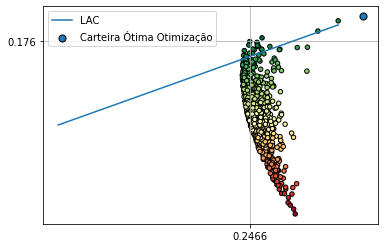

In [307]:
plt.scatter(x = resultados_simulacoes_carteira['Desvio Padrão'], y = resultados_simulacoes_carteira['Retorno'], c = resultados_simulacoes_carteira['Sharpe'],
            s=20, cmap='RdYlGn', edgecolors='black' )
plt.scatter(x = desvio_otimo, y = retorno_otimo, s = 50, edgecolors = 'black',
            label='Carteira Ótima Otimização')
plt.plot(x, lac, label = 'LAC')
#plt.ylim((-0.05,0.05))
#plt.xlim((0,0.2))
plt.yticks(carteira_maior_sharpe['Retorno'])
plt.xticks(carteira_maior_sharpe['Desvio Padrão'])
plt.grid()
plt.legend()

In [299]:
(retorno_simulacoes-rf) / desvio_simulacoes

array([ 2.02345190e-01, -1.85243684e-01,  2.24163304e-01,  9.51175793e-02,
        1.32069397e-01, -8.04093324e-02,  3.39914007e-01,  1.50060669e-01,
        4.56623421e-02, -1.73022796e-01,  2.11654076e-02,  4.38481382e-02,
        1.99498644e-01,  1.87704877e-01,  1.86134071e-01, -1.09454039e-01,
        6.36787551e-02, -1.02649138e-01,  1.43397262e-01,  3.44182994e-02,
        1.25132534e-01, -2.20011333e-01,  2.21938797e-01, -1.91424075e-01,
        3.48151631e-01,  2.45035266e-01,  6.14870925e-02,  3.86368704e-03,
       -1.15394215e-02,  2.00902041e-02,  2.68259911e-01,  1.50004646e-01,
        1.86278618e-01, -1.58423103e-01,  4.08692944e-01,  2.51781616e-01,
        2.33601640e-01,  2.23322920e-01,  3.35604079e-01,  4.58391102e-01,
        3.65069373e-02, -2.86427216e-02, -1.94767179e-01,  8.38082677e-02,
        1.92824246e-01,  6.33296724e-02,  2.41260265e-01,  1.84772714e-01,
        1.91072336e-01,  4.66414672e-02,  5.51144434e-02,  1.77724636e-02,
       -3.03094662e-01,  

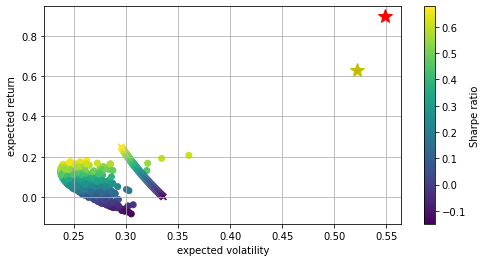

In [297]:
plt.figure(figsize=(8, 4))
plt.scatter(desvio_simulacoes, retorno_simulacoes, c=(retorno_simulacoes-rf) / desvio_simulacoes, marker='o') # random portfolio composition
plt.scatter(alvo_vol, alvo_ret,c=(alvo_ret-rf) / alvo_vol, marker='x')# efficient frontier
plt.plot(statistics(opts['x'])[1], statistics(opts['x'])[0],'r*', markersize=15.0)# portfolio with highest Sharpe ratio
plt.plot(statistics(optv['x'])[1], statistics(optv['x'])[0],'y*', markersize=15.0)# minimum variance portfolio
plt.grid(True)
plt.xlabel('expected volatility')
plt.ylabel('expected return')
plt.colorbar(label='Sharpe ratio')